In [1]:
import torch

# Check if CUDA (GPU support) is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Get number of available GPUs
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Get current GPU name (if available)
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

CUDA available: True
Number of GPUs: 8
Current GPU: NVIDIA GeForce RTX 4090 D


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from collections import defaultdict
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from shutil import copytree, rmtree, copy
from PIL import Image


In [ ]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")


In [ ]:

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ", food)
        if not os.path.exists(os.path.join(dest, food)):
            os.makedirs(os.path.join(dest, food))
        for i in classes_images[food]:
            copy(os.path.join(src, food, i), os.path.join(dest, food, i))
    print("Copying Done!")

def dataset_mini(food_list, src, dest):
    if os.path.exists(dest):
        rmtree(dest)
    os.makedirs(dest)
    for food_item in food_list:
        print("Copying images into", food_item)
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))


In [ ]:

# Data preprocessing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=20, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:

# Fine-tuning ResNet50 with 3 classes
def create_model(n_classes):
    model = models.resnet50(pretrained=True)
    
    # Freeze feature layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Modify the final layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, n_classes),
        nn.Softmax(dim=1)
    )
    
    return model.to(device)


In [ ]:

# Training function
def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * correct / total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')
    
    return history


In [ ]:

# Plotting functions
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


In [4]:
# Calorie lookup table (calories per standard serving)
CALORIE_TABLE = {
    'apple_pie': 296,  # Approx. calories per slice (100g)
    'pizza': 266,      # Approx. calories per slice (100g)
    'omelette': 240    # Approx. calories for a 2-egg omelette (100g)
}

# Prediction function with calorie estimation
def predict_class(model, images, class_names, show=True):
    model.eval()
    for img_path in images:
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transforms(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            pred_class = class_names[predicted.item()]
            calorie_estimation = CALORIE_TABLE.get(pred_class, 0)  # Get calories, default to 0 if not found
        
        if show:
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{pred_class} - {calorie_estimation} calories (per 100g)")
            plt.show()
        print(f"Predicted: {pred_class}, Estimated Calories: {calorie_estimation} per 100g")

In [ ]:

# Prediction function
def predict_class(model, images, class_names, show=True):
    model.eval()
    for img_path in images:
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transforms(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            pred_class = class_names[predicted.item()]
        
        if show:
            plt.imshow(img)
            plt.axis('off')
            plt.title(pred_class)
            plt.show()


In [ ]:

# Main execution
if __name__ == "__main__":
    # Set your local paths
    base_path = '/root/VLM/kaggle/input/food-101'
    train_path = '/train'  # This will be created in root directory
    test_path = '/test'    # This will be created in root directory
    train_mini_path = os.path.join(base_path, 'train_mini')
    test_mini_path = os.path.join(base_path, 'test_mini')

    # Prepare data
    os.chdir('/')
    print("Creating train data...")
    prepare_data(os.path.join(base_path, 'meta/train.txt'), 
                os.path.join(base_path, 'images'), train_path)
    print("Creating test data...")
    prepare_data(os.path.join(base_path, 'meta/test.txt'), 
                os.path.join(base_path, 'images'), test_path)
    
    # Create mini dataset with 3 classes
    food_list = ['apple_pie', 'pizza', 'omelette']
    dataset_mini(food_list, train_path, train_mini_path)
    dataset_mini(food_list, test_path, test_mini_path)
    
    # Load data
    train_dataset = torchvision.datasets.ImageFolder(train_mini_path, transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(test_mini_path, transform=test_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Create and train model
    model = create_model(n_classes=3)
    history = train_model(model, train_loader, val_loader)
    
    # Save model
    torch.save(model.state_dict(), os.path.join(base_path, 'model_trained_3class.pth'))
    

    # Plot results
    plot_accuracy(history, 'FOOD101-ResNet50')
    plot_loss(history, 'FOOD101-ResNet50')
    

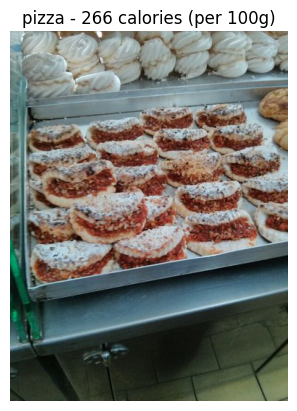

Predicted: pizza, Estimated Calories: 266 per 100g


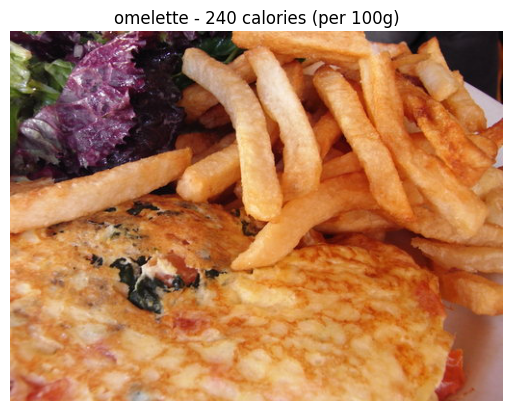

Predicted: omelette, Estimated Calories: 240 per 100g


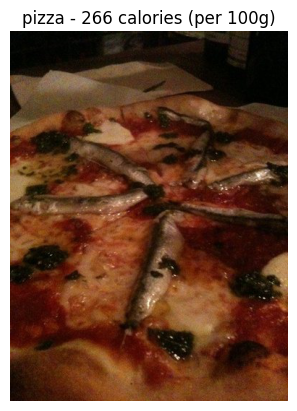

Predicted: pizza, Estimated Calories: 266 per 100g


In [5]:

    # Test with local images (update these paths to your local test images)
    images = [
        '/root/VLM/kaggle/input/food-101/working/train_mini/apple_pie/3783821.jpg',
        '/root/VLM/kaggle/input/food-101/working/train_mini/omelette/5932.jpg',
        '/root/VLM/kaggle/input/food-101/working/train_mini/pizza/12301.jpg'
    ]
    class_names = train_dataset.classes
    predict_class(model, images, class_names)